<center>
<img src="https://quantumrickusach.notion.site/image/https%3A%2F%2Fprod-files-secure.s3.us-west-2.amazonaws.com%2Fcabb6d21-467a-4eab-beff-81a08cc5ecdb%2F0592fbd9-722d-4175-9604-eae98bf718b1%2FCaptura_de_pantalla_2024-08-14_a_la(s)_5.30.50_a._m..png?table=block&id=305d81b1-7009-41ae-a80b-8a8e20a4f9c1&spaceId=cabb6d21-467a-4eab-beff-81a08cc5ecdb&width=2000&userId=&cache=v2">

# QuSantiago III

 Dictado por: Ricardo Quispe

# <center> Qiskit: Optimización de una secuencia de pulsos

Aquí, analizamos un ejemplo de optimización de una puerta de un solo cúbit con Qiskit Dynamics. Este tutorial requiere JAX: consulte la guía del usuario sobre cómo usar JAX con qiskit-dynamics.

Optimizaremos una puerta en un modelo de un sistema de qubit mediante los siguientes pasos:

- Configurar JAX.

- Configurar una instancia de Solver con el modelo del sistema.

- Definir una parametrización de secuencia de pulsos para optimizar.

- Definir una función de fidelidad de puerta.

- Definir una función objetivo para la optimización.

- Utilizar JAX para diferenciar el objetivo y luego realizar la optimización del gradiente.

- Repetir la optimización de la puerta, alternativamente utilizando programas de pulsos para especificar la secuencia de control.

## 1. Configurar el solver con el modelo hamiltoniano

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp

$$H(t) = 2 \pi \nu \frac{Z}{2} + 2 \pi r s(t) \frac{X}{2}$$



$\nu$ is the qubit frequency,

$r$ is the drive strength,

$s(t)$ is the drive signal which we will optimize, and


$X$ and $Z$ are the Pauli X and Z operators.

In [2]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver

v = 5.
r = 0.02

static_hamiltonian = 2 * np.pi * v * Operator.from_label('Z') / 2
drive_term = 2 * np.pi * r * Operator.from_label('X') / 2

ham_solver = Solver(
    hamiltonian_operators=[drive_term],
    static_hamiltonian=static_hamiltonian,
    rotating_frame=static_hamiltonian,
)

### 3. Definir una parametrización de la secuencia de pulsos para optimizar

Vamos a optimizar señales que sean:

- Ajustadas a la resonancia con envolventes constantes por tramos,
- Envolventes acotadas entre $[-1, 1]$,
- Envolventes suaves, en el sentido de que el cambio entre muestras adyacentes es pequeño, y
- La envolvente comienza y termina en $0$.

Al configurar nuestra parametrización, debemos tener en cuenta que usaremos el método de optimización BFGS, y por lo tanto:

- Los parámetros de optimización deben ser no restringidos.
- La parametrización debe ser diferenciable con JAX.

Implementamos una parametrización de la siguiente manera:

1. Entrada: Array $x$ de valores reales.

2. “Normalizar” $x$ aplicando una función diferenciable con JAX de $\mathbb{R} \rightarrow
[-1, 1]$.

3. Rellenar el $x$ normalizado con un $0$ al principio.

4. “Suavizar” lo anterior mediante convolución.

5. Construir la señal usando los valores anteriores como las muestras para una envolvente constante por tramos, con la frecuencia portadora en resonancia.

Observamos que hay muchas otras parametrizaciones que pueden lograr los mismos objetivos y pueden tener estrategias más eficientes para lograr un valor de $0$ al principio y al final del pulso. Esto solo pretende demostrar la necesidad de tal enfoque y un ejemplo simple de uno.

In [3]:
from qiskit_dynamics import DiscreteSignal
from qiskit_dynamics.signals import Convolution

import jax.numpy as jnp

# define convolution filter
def gaus(t):
    sigma = 15
    _dt = 0.1
    return 2.*_dt/np.sqrt(2.*np.pi*sigma**2)*np.exp(-t**2/(2*sigma**2))

convolution = Convolution(gaus)

# define function mapping parameters to signals
def signal_mapping(params):

    # map samples into [-1, 1]
    bounded_samples = jnp.arctan(params) / (np.pi / 2)

    # pad with 0 at beginning
    padded_samples = jnp.append(jnp.array([0], dtype=complex), bounded_samples)

    # apply filter
    output_signal = convolution(DiscreteSignal(dt=1., samples=padded_samples))

    # set carrier frequency to v
    output_signal.carrier_freq = v

    return output_signal

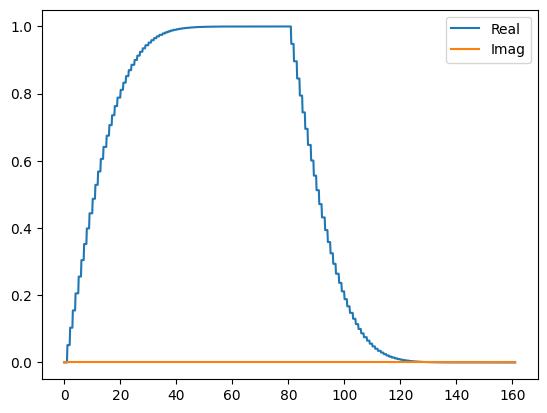

In [4]:
signal = signal_mapping(np.ones(80) * 1e8)
signal.draw(t0=0., tf=signal.duration * signal.dt, n=1000, function='envelope')

In [5]:

X_op = Operator.from_label('X').data

def fidelity(U):
    return jnp.abs(jnp.sum(X_op * U))**2 / 4.

In [6]:
def objective(params):

    # apply signal mapping and set signals
    signal = signal_mapping(params)

    # Simulate
    results = ham_solver.solve(
        y0=np.eye(2, dtype=complex),
        t_span=[0, signal.duration * signal.dt],
        signals=[signal],
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8
    )
    U = results.y[-1]

    # compute and return infidelity
    fid = fidelity(U)
    return 1. - fid

In [7]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

jit_grad_obj = jit(value_and_grad(objective))

initial_guess = np.random.rand(80) - 0.5

opt_results = minimize(fun=jit_grad_obj, x0=initial_guess, jac=True, method='BFGS')
print(opt_results.message)
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))

Optimization terminated successfully.
Number of function evaluations: 12
Function value: -1.7200218582757998e-08


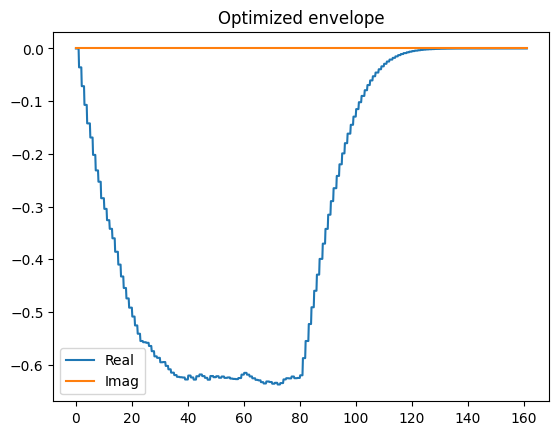

In [8]:
opt_signal = signal_mapping(opt_results.x)

opt_signal.draw(
    t0=0,
    tf=opt_signal.duration * opt_signal.dt,
    n=1000,
    function='envelope',
    title='Optimized envelope'
)

In [9]:
opt_signal.samples.sum()


Array(-50.00650982, dtype=float64)

### Repita la optimización de la puerta $X$, utilizando alternativamente programas de pulsos para especificar la secuencia de control

Aquí, realizamos la optimización nuevamente, pero ahora especificamos la secuencia de control parametrizada para optimizar como un programa de pulsos.

Construimos un pulso cuadrado gaussiano como una instancia de ScalableSymbolicPulse, parametrizada por sigma y ancho. Aunque el pulso qiskit proporciona un GaussianSquare, esta clase no es compatible con JAX. Consulte la entrada de la guía del usuario sobre los programas de pulsos compatibles con JAX.

In [10]:
import sympy as sym
from qiskit import pulse

def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

def gaussian_square_generated_by_pulse(params):

    sigma, width = params
    _t, _duration, _amp, _sigma, _width, _angle = sym.symbols(
        "t, duration, amp, sigma, width, angle"
    )
    _center = _duration / 2

    _sq_t0 = _center - _width / 2
    _sq_t1 = _center + _width / 2

    _gaussian_ledge = lifted_gaussian(_t, _sq_t0, -1, _sigma)
    _gaussian_redge = lifted_gaussian(_t, _sq_t1, _duration + 1, _sigma)

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * sym.Piecewise(
            (_gaussian_ledge, _t <= _sq_t0), (_gaussian_redge, _t >= _sq_t1), (1, True)
        )
    )

    # we need to set disable_validation True to enable jax-jitting.
    pulse.ScalableSymbolicPulse.disable_validation = True

    return pulse.ScalableSymbolicPulse(
            pulse_type="GaussianSquare",
            duration=230,
            amp=1,
            angle=0,
            parameters={"sigma": sigma, "width": width},
            envelope=envelope_expr,
            constraints=sym.And(_sigma > 0, _width >= 0, _duration >= _width),
            valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )

A continuación, construimos una programación de pulsos utilizando el pulso cuadrado gaussiano parametrizado anteriormente, lo convertimos en una señal y simulamos la ecuación a lo largo de la secuencia de pulsos.

In [11]:
from qiskit_dynamics.pulse import InstructionToSignals

dt = 0.222
w = 5.

def objective(params):

    instance = gaussian_square_generated_by_pulse(params)

    with pulse.build() as Xp:
        pulse.play(instance, pulse.DriveChannel(0))

    converter = InstructionToSignals(dt, carriers={"d0": w})
    signal = converter.get_signals(Xp)

    result = ham_solver.solve(
        y0=np.eye(2, dtype=complex),
        t_span=[0, instance.duration * dt],
        signals=[signal],
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8
    )
    return 1. - fidelity(result[0].y[-1])

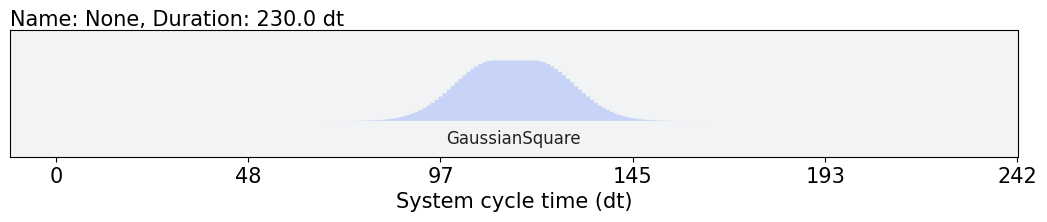

In [12]:
initial_params = np.array([10, 10])
gaussian_square_generated_by_pulse(initial_params).draw()

In [13]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

jit_grad_obj = jit(value_and_grad(objective))

initial_params = np.array([10,10])


opt_results = minimize(fun=jit_grad_obj, x0=initial_params, jac=True, method='BFGS')

print(opt_results.message)
print(f"Optimized Sigma is {opt_results.x[0]} and Width is {opt_results.x[1]}")
print('Number of function evaluations: ' + str(opt_results.nfev))
print('Function value: ' + str(opt_results.fun))

Optimization terminated successfully.
Optimized Sigma is 516.350965164561 and Width is 212.1840341449244
Number of function evaluations: 14
Function value: 1.7325514933830277e-07


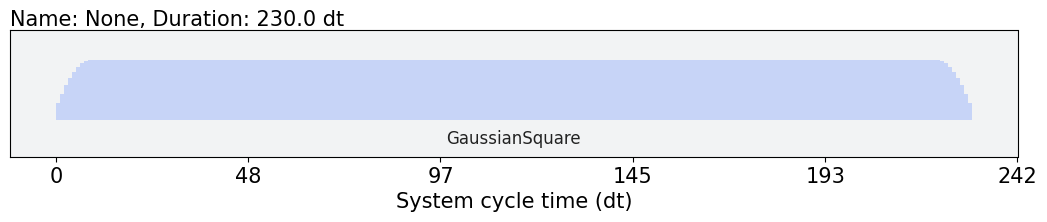

In [14]:
gaussian_square_generated_by_pulse(opt_results.x).draw()


#### References

- Gradient optimization of a pulse sequence(https://qiskit-community.github.io/qiskit-dynamics/tutorials/optimizing_pulse_sequence.html)
- Evaluating analytic gradients of pulse programs on quantum computers https://arxiv.org/pdf/2309.16756